In [1]:
#@title Instalar dependencias (ejecuta una vez por sesión)
!pip -q install numpy pandas scipy scikit-learn imbalanced-learn joblib matplotlib tqdm pyyaml


In [3]:
#@title Montar Google Drive y crear carpetas
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/cwru_pipeline"   # <- cámbialo si quieres
import os
for d in ["raw","interim","features","models","reports"]:
    os.makedirs(f"{BASE_DIR}/{d}", exist_ok=True)
print("Base:", BASE_DIR)


Mounted at /content/drive
Base: /content/drive/MyDrive/cwru_pipeline


In [4]:
#@title Descargar ejemplos (puedes editar la lista)
import os, requests

BASE = "https://engineering.case.edu/sites/default/files"  # host de archivos .mat de CWRU
files = {
    # Normal baseline (algunos vienen como números; añadimos uno común, edita si falla)
    "normal_0.mat": "97.mat",     # si no funciona, sube tus normales a mano desde "Normal Baseline Data"
    # Fallos a 12kHz Drive End (IR/B/OR). Puedes añadir más (IR014_*, B014_*, etc)
    "IR007_0.mat": "105.mat",
    "B007_0.mat":  "122.mat",
    "OR007@6_0.mat": "132.mat",
}

raw_dir = f"{BASE_DIR}/raw"
os.makedirs(raw_dir, exist_ok=True)

for name, remote in files.items():
    url = f"{BASE}/{remote}"
    out = os.path.join(raw_dir, name)
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        with open(out, "wb") as f:
            f.write(r.content)
        print("Descargado:", name)
    except Exception as e:
        print("No se pudo descargar", name, "->", e, "\nSube este archivo manualmente desde la página oficial.")


Descargado: normal_0.mat
Descargado: IR007_0.mat
Descargado: B007_0.mat
Descargado: OR007@6_0.mat


In [5]:
#@title Loader robusto para CWRU + construcción de DataFrame
import numpy as np, pandas as pd, re, glob, os, warnings

def try_loadmat(path):
    """Devuelve dict-like con claves de nivel superior usando loadmat o h5py."""
    try:
        from scipy.io import loadmat
        m = loadmat(path, squeeze_me=True, struct_as_record=False)
        return m, "scipy"
    except Exception as e:
        warnings.warn(f"loadmat falló en {os.path.basename(path)}: {e}. Intentando h5py…")
        try:
            import h5py
            h5 = h5py.File(path, 'r')
            return h5, "h5py"
        except Exception as e2:
            raise RuntimeError(f"No se pudo leer {path} ni con scipy.io ni con h5py: {e2}")

def flatten_h5(h5obj):
    """Convierte datasets h5py en un dict plano {name: np.array}."""
    import h5py
    out = {}
    def visit(name, obj):
        if isinstance(obj, h5py.Dataset):
            try:
                out[name] = np.array(obj[()]).squeeze()
            except Exception:
                pass
    h5obj.visititems(lambda name, obj: visit(name, obj))
    return out

PAT_ENDINGS = [
    r'(?:^|_)DE_time$', r'(?:^|_)FE_time$', r'(?:^|_)BA_time$',
    r'(?:^|_)DE$', r'(?:^|_)FE$', r'(?:^|_)BA$'
]
compiled = [re.compile(pat, re.IGNORECASE) for pat in PAT_ENDINGS]

def extract_channels(mat_obj, loader_kind):
    """
    Retorna dict con posibles claves: DE_time, FE_time, BA_time (o DE/FE/BA)
    """
    out = {}
    if loader_kind == "scipy":
        # Caso 1: struct 'X' u otros structs
        # Recolectar todas las claves nivel 1
        keys = [k for k in mat_obj.keys() if not k.startswith("__")]
        # Intentar si hay 'X' (estructura clásica)
        if 'X' in keys:
            X = mat_obj['X']  # puede ser struct con atributos
            for cand in ['DE_time','FE_time','BA_time','DE','FE','BA','RPM']:
                if hasattr(X, cand):
                    arr = getattr(X, cand)
                    try:
                        out[cand] = np.asarray(arr, dtype=float).squeeze()
                    except Exception:
                        pass
        # Si no salió, barrer TODAS las claves planas y quedarse con las que matcheen los sufijos
        # Además, hay archivos con nombres tipo 'X097_DE_time'
        for k in keys:
            try:
                val = mat_obj[k]
                # si es un numpy void (struct) ignoramos aquí; arriba ya intentamos 'X'
                arr = None
                if not hasattr(val, 'dtype') or val.dtype != np.void:
                    arr = np.asarray(val).squeeze()
                # chequear patrones de nombre
                for rx in compiled:
                    if rx.search(k):
                        # mapear clave a nombre canónico
                        if 'DE_time' in k or re.search(r'DE_time$', k, re.I):
                            out['DE_time'] = arr.astype(float)
                        elif 'FE_time' in k or re.search(r'FE_time$', k, re.I):
                            out['FE_time'] = arr.astype(float)
                        elif 'BA_time' in k or re.search(r'BA_time$', k, re.I):
                            out['BA_time'] = arr.astype(float)
                        elif re.search(r'(?:^|_)DE$', k, re.I):
                            out['DE'] = arr.astype(float)
                        elif re.search(r'(?:^|_)FE$', k, re.I):
                            out['FE'] = arr.astype(float)
                        elif re.search(r'(?:^|_)BA$', k, re.I):
                            out['BA'] = arr.astype(float)
                        break
            except Exception:
                pass
    else:  # h5py
        flat = flatten_h5(mat_obj)
        for k, v in flat.items():
            for rx in compiled:
                if rx.search(k):
                    if re.search(r'DE_time$', k, re.I):
                        out['DE_time'] = v.astype(float)
                    elif re.search(r'FE_time$', k, re.I):
                        out['FE_time'] = v.astype(float)
                    elif re.search(r'BA_time$', k, re.I):
                        out['BA_time'] = v.astype(float)
                    elif re.search(r'(?:^|_)DE$', k, re.I):
                        out['DE'] = v.astype(float)
                    elif re.search(r'(?:^|_)FE$', k, re.I):
                        out['FE'] = v.astype(float)
                    elif re.search(r'(?:^|_)BA$', k, re.I):
                        out['BA'] = v.astype(float)
                    break
    return out

def load_cwru_any(path):
    obj, kind = try_loadmat(path)
    chans = extract_channels(obj, kind)
    return chans

def file_to_label(fname):
    base = os.path.basename(fname)
    b = base.lower()
    # normal si el nombre contiene 'normal' o es numérico puro (97.mat), o si contiene X097/X098/X099/X100
    if ("normal" in b) or re.match(r"^\d+\.mat$", base) or re.search(r"x0?(97|98|99|100)", b):
        return "NORMAL"
    if b.startswith("ir") or "ir" in b: return "IR"
    if b.startswith("b")  or re.search(r'\bb\d+', b): return "B"
    if b.startswith("or") or "or" in b: return "OR"
    return "UNKNOWN"


def build_dataframe_from_files(raw_dir=f"{BASE_DIR}/raw",prefer=("DE_time","DE","FE_time","FE","BA_time","BA")):
    rows = []
    paths = sorted(glob.glob(os.path.join(raw_dir, "*.mat"))  + glob.glob(os.path.join(raw_dir, "*.MAT")))
    if not paths:
        raise FileNotFoundError("No hay .mat en RAW_DIR.")
    skipped = []
    for p in paths:
        try:
            chans = load_cwru_any(p)
            # elige el primer canal disponible en orden de preferencia
            sel = None
            for c in prefer:
                if c in chans:
                    sel = chans[c]
                    break
            if sel is None or len(sel)==0:
                skipped.append(p);
                continue
            lbl = file_to_label(p)
            rows.append(pd.DataFrame({
                "file": os.path.basename(p),
                "idx": np.arange(len(sel)),
                "signal": np.asarray(sel, dtype=float),
                "label_file": lbl
            }))
        except Exception as e:
            skipped.append(p)
            print("Saltado por error:", os.path.basename(p), "->", e)
    if not rows:
        raise ValueError(f"No se pudo leer ningún canal utilizable. Skipped: {len(skipped)} archivos.")
    df = pd.concat(rows, ignore_index=True)
    if skipped:
        print("Advertencia: se omitieron", len(skipped), "archivos sin canal utilizable.")
        for s in skipped[:10]:
            print(" -", os.path.basename(s))
    return df

df_raw = build_dataframe_from_files()
print(df_raw.head())
print(df_raw["label_file"].value_counts())


         file  idx    signal label_file
0  B007_0.mat    0 -0.111192          B
1  B007_0.mat    1 -0.083029          B
2  B007_0.mat    2 -0.042349          B
3  B007_0.mat    3  0.008970          B
4  B007_0.mat    4  0.057578          B
label_file
B         244739
NORMAL    243938
OR        121410
IR        121265
Name: count, dtype: int64


In [6]:
df_raw["label_file"].value_counts()

,count
label_file,
B,244739
NORMAL,243938
OR,121410
IR,121265


In [7]:
# Parámetros
FS_ASSUMED = 12000   # Hz típicos de CWRU (drive end 12k)
FS_TARGET  = 4000    # baja resolución para acelerar
LOWPASS_CUTOFF = 0.4 * (FS_TARGET/2)  # ~800 Hz
WIN_SEC   = 1.0
OVERLAP   = 0.5

from scipy import signal
import numpy as np
import pandas as pd
from tqdm import tqdm

def butter_lowpass_filter(x, fs, cutoff_hz, order=4):
    nyq = 0.5*fs
    wn = cutoff_hz/nyq
    b,a = signal.butter(order, wn, btype='low')
    return signal.filtfilt(b,a,x)

def preprocess_and_resample_1d(x, fs_raw=FS_ASSUMED, fs_target=FS_TARGET, lowpass_cutoff=LOWPASS_CUTOFF):
    x = signal.detrend(x, type='linear')
    x = butter_lowpass_filter(x, fs_raw, lowpass_cutoff)
    n = int(len(x) * fs_target / fs_raw)
    return signal.resample(x, n)

def window_indices(n, win, step):
    out=[]; i=0
    while i+win<=n:
        out.append((i,i+win))
        i += step
    return out

WIN = int(WIN_SEC*FS_TARGET)
STEP = int(WIN*(1-OVERLAP))

# Ventanas por archivo para mantener etiqueta correcta
feat_rows = []
for fname, g in tqdm(df_raw.groupby("file"), total=df_raw["file"].nunique()):
    x = g["signal"].values
    y_file = g["label_file"].iloc[0]
    xr = preprocess_and_resample_1d(x)
    idxs = window_indices(len(xr), WIN, STEP)
    for a,b in idxs:
        seg = xr[a:b]
        if len(seg)<WIN:
            continue
        feat_rows.append({
            "file": fname,
            "label": y_file,
            "signal_seg": seg
        })

df_segs = pd.DataFrame(feat_rows)
print(len(df_segs), "ventanas")
df_segs["label"].value_counts()


100%|██████████| 4/4 [00:00<00:00, 13.59it/s]

116 ventanas


,count
label,
B,39
NORMAL,39
IR,19
OR,19


In [8]:
from scipy.stats import kurtosis, skew
from scipy.signal import welch

def bandpower(x, fs, fmin, fmax, nperseg=1024):
    f, Pxx = welch(x, fs=fs, nperseg=min(nperseg, len(x)))
    m = (f>=fmin)&(f<=fmax)
    if not np.any(m): return 0.0
    return np.trapz(Pxx[m], f[m])

def spectral_centroid(x, fs):
    f, Pxx = welch(x, fs=fs, nperseg=min(1024, len(x)))
    s = Pxx.sum()
    return float((f*Pxx).sum()/s) if s>0 else 0.0

def spectral_entropy(x, fs, eps=1e-12):
    f, Pxx = welch(x, fs=fs, nperseg=min(1024, len(x)))
    Pxx = Pxx/(Pxx.sum()+eps)
    return float(-(Pxx*np.log2(Pxx+eps)).sum())

def extract_feats_from_seg(x):
    feats = {}
    feats["mean"] = np.mean(x)
    feats["std"] = np.std(x)
    feats["rms"] = np.sqrt(np.mean(x**2))
    feats["kurtosis"] = float(kurtosis(x, fisher=True, bias=False))
    feats["skew"] = float(skew(x, bias=False))
    feats["p2p"] = float(np.ptp(x))
    feats["spec_centroid"] = spectral_centroid(x, FS_TARGET)
    feats["spec_entropy"] = spectral_entropy(x, FS_TARGET)
    # bandas ejemplo
    bands = [(0,50),(50,200),(200,800),(800, FS_TARGET/2)]
    for i,(f1,f2) in enumerate(bands):
        feats[f"band_{i}_{int(f1)}_{int(f2)}"] = bandpower(x, FS_TARGET, f1, f2)
    return feats

feat_table = []
for _, row in df_segs.iterrows():
    fts = extract_feats_from_seg(row["signal_seg"])
    fts.update({"label": row["label"], "file": row["file"]})
    feat_table.append(fts)

feat_df = pd.DataFrame(feat_table)
feat_df.head(), feat_df["label"].value_counts()


/tmp/ipython-input-2025149693.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Pxx[m], f[m])


(       mean       std       rms  kurtosis      skew       p2p  spec_centroid  \
 0 -0.000050  0.099404  0.099404  0.209479 -0.022582  0.769747     645.989860   
 1  0.000646  0.097963  0.097965  0.011667  0.002503  0.694934     650.958048   
 2  0.001003  0.095901  0.095906 -0.046805 -0.021221  0.707991     627.731623   
 3 -0.000224  0.096190  0.096190  0.118221  0.006868  0.716522     619.808119   
 4 -0.000752  0.098925  0.098928  0.031667 -0.038089  0.722488     635.614340   
 
    spec_entropy  band_0_0_50  band_1_50_200  band_2_200_800  band_3_800_2000  \
 0      6.397672     0.000163       0.000527        0.007171         0.001523   
 1      6.199093     0.000172       0.000494        0.007767         0.001471   
 2      6.232097     0.000181       0.000624        0.007415         0.000915   
 3      6.365409     0.000167       0.000819        0.007218         0.001098   
 4      6.360308     0.000159       0.000687        0.007641         0.001328   
 
   label        file  
 

== Classification report ==
              precision    recall  f1-score   support

           B       1.00      1.00      1.00         8
          IR       1.00      1.00      1.00         8
      NORMAL       1.00      1.00      1.00         8
          OR       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Labels: ['B', 'IR', 'NORMAL', 'OR']
Confusion matrix:
 [[8 0 0 0]
 [0 8 0 0]
 [0 0 8 0]
 [0 0 0 8]]


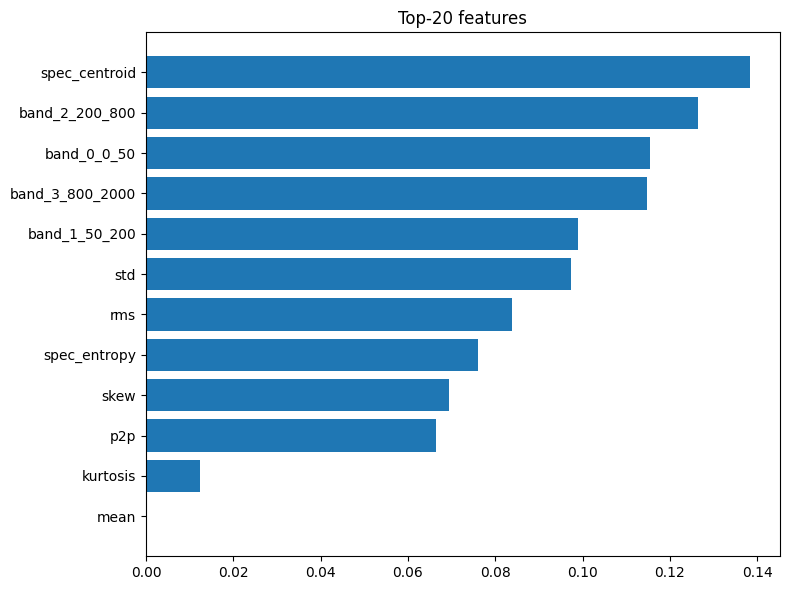

Guardados en /models/


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt

X = feat_df.drop(columns=["label","file"], errors="ignore")
y = feat_df["label"].astype(str)

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceo (SMOTE)
sm = SMOTE(random_state=42)
Xs, ys = sm.fit_resample(X_scaled, y)

# Split
Xtr, Xte, ytr, yte = train_test_split(Xs, ys, test_size=0.2, random_state=42, stratify=ys)

# Modelo
clf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)

print("== Classification report ==")
print(classification_report(yte, yp))
cm = confusion_matrix(yte, yp, labels=sorted(np.unique(ys)))
print("Labels:", sorted(np.unique(ys)))
print("Confusion matrix:\n", cm)

# Top features
imp = clf.feature_importances_
order = np.argsort(imp)[::-1][:20]
plt.figure(figsize=(8,6))
plt.barh(np.array(X.columns)[order][::-1], imp[order][::-1])
plt.title("Top‑20 features")
plt.tight_layout()
plt.show()

# Guardar
BASE_DIR = "/content/drive/MyDrive/cwru_pipeline"
dump(clf, f"{BASE_DIR}/models/rf_cwru.joblib")
dump(scaler, f"{BASE_DIR}/models/scaler.joblib")
print("Guardados en /models/")
